## Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in the gravitational-wave class; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course, careful with overfitting here).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.
- Plot ROC curves
- **Important** Don't use `snr` as feature in your classifer (that's the answer...)


### Other ideas (optional)

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

In [20]:
import h5py

# open file in read mode
with h5py.File('../../../dati_ligo.h5', 'r') as file:
    keys = list(file.keys())
    print("Keys in the file:")
    print(list(file.keys()))
    i = 5  # choose which event/row to print

    print(f"Event # {i}")
    for key in keys:
        print(f"{key}: {file[key][i]} \n")

Keys in the file:
['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
Event # 5
chi1x: 0.4443011011013645 

chi1y: -0.3130145910330952 

chi1z: -0.057333079484898554 

chi2x: 0.22085572377089832 

chi2y: -0.05548154598256885 

chi2z: 0.24863691324053133 

dec: -0.026682087276974187 

det: 0 

iota: 2.625059540986772 

mtot: 529.9026588479699 

psi: 1.1264916491093253 

q: 0.42260358914077123 

ra: 1.0615684259712772 

snr: 1.8936316227212333 

z: 3.2466847227573146 



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

N = 100_000 

with h5py.File('../../../dati_ligo.h5', 'r') as file:
    data_dict = {key: file[key][:N] for key in tqdm(file.keys(), desc="data load")}
df = pd.DataFrame(data_dict)

df_visible = df[df['snr'] >= 12]  #  threshold for visible signals

print(f"number of visible signals: {len(df_visible)} over {N} total signals")
print(f"percentage of visible signals: {len(df_visible) / N * 100:.2f}%")

data load:   0%|          | 0/15 [00:00<?, ?it/s]

data load: 100%|██████████| 15/15 [00:00<00:00, 92.11it/s]

number of visible signals: 14382 over 100000 total signals
percentage of visible signals: 14.38%


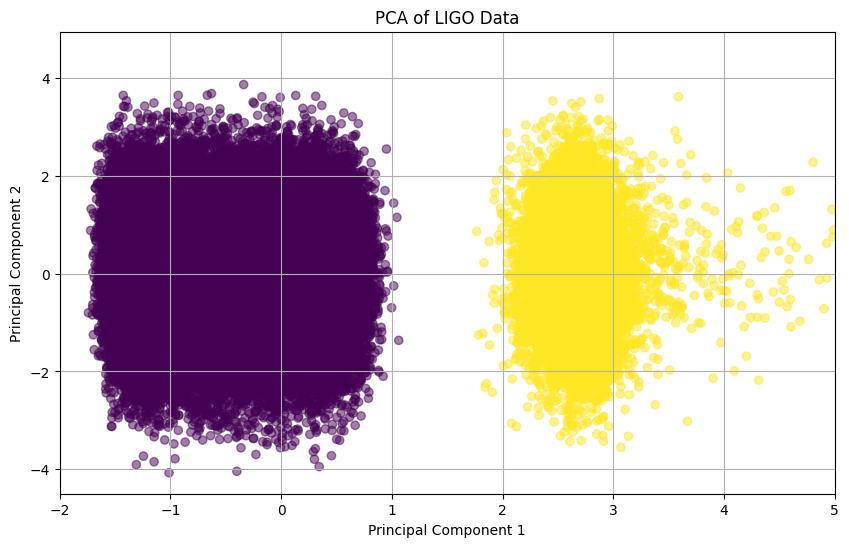

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(df)
y = np.array(df['det'])

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('PCA of LIGO Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.xlim(-2, 5)
plt.show() 

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

In [24]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                      subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train)

/mnt/c/Users/ASUS/Desktop/WSL_Shared/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:13:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

/tmp/ipykernel_49113/3812019555.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(fpr, tpr)


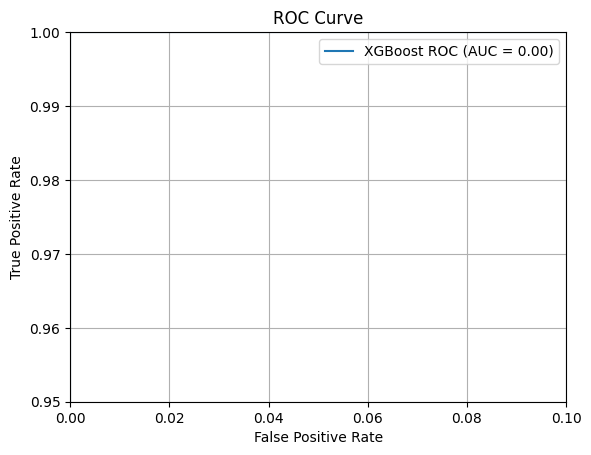

Completeness: 1.00, Contamination: 0.00


In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix

y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = np.trapz(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.xlim(0, 0.5)
plt.ylim(0.95, 1)
plt.show()

y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}, Contamination: {contamination:.2f}")
